*introduction to dataset, problem statement*

*show an example of a data text file, and the process of how this is parsed*

## Import modules

In [1]:
import numpy as np
import pandas as pd
import os.path
import time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

## Define global variables

In [2]:
# dictionary of chord (key) to numeral (value)
CHORD_DICT = {
    'A':0,
    'A#':1,
    'Bb':1,
    'B':2,
    'Cb':2,
    'C':3,
    'C#':4,
    'Db':4,
    'D':5,
    'D#':6,
    'Eb':6,
    'E':7,
    'Fb':7,
    'F':8,
    'F#':9,
    'Gb':8,
    'G':10,
    'G#':11,
    'Ab':11,
}

# dictionary of quality to simplified quality
QUALITY_DICT = {
    'min7':'min',
    'sus4':'sus',
    'maj7':'maj',
    'maj6':'maj',
    'min9':'min',
    'maj9':'maj',
    '9':'7',
    '11':'7',
    'sus2':'sus',
    '13':'7',
    'min6':'min',
    'min11':'min',
    'hdim7':'dim',
    'maj13':'maj',
    'dim7':'dim',
    'minmaj7':'min',
    'min13':'min'
}

# absolute path to McGill Billboard data
MCGILL_PATH = os.path.expanduser("~") + "/biof509/final-project/data/McGill-Billboard"

# bool to indicate whether to simplify quality of chords
QUALITY_SIMPLIFY = True

# bool to indicate whether to normalize data based on the total number of sequences of a
#   certain length found in a song (reflective of the size of a song)
NORM = False

# list of sequence lengths to search for
SEQ_LEN_LIST = [2,3,4]

# number of chart rank categories to bin into
NUM_CATEGORIES = 5

## Define Functions

In [3]:
def parse_data(path):
    """
    Funtion parse_data parses text file provided from the McGill Billboard
    project and returns two lists of lists containing a sequence of chords
    and their qualities respectively
    -----------------------
    Input
        path: string containing absolute path to text file to parse
    
    Output
        chords: list of lists; each inner list corresponds to a chord sequence
            in an individual line of the song, and contains 2-element tuples
            that give the relative chord numeral and its quality
    """
    # initialize global list
    chords = []
    # iterate over every line
    for line in open(path):
        # set new tonic, if applicable
        if "# tonic:" in line:
            tonic = line.rsplit(" ")[-1][:-1]
        # initialize line-specific lists
        chords_line = []
        # split bars (separated by "|")
        bars = line.rsplit("|")[1:-1]
        # iterate over bars
        for bar in bars:
            # split chords+quality (separated by space)
            cqs = bar.rsplit(" ")[1:-1]
            # iterate over chords+quality
            for cq in cqs:
                # check for existence of ":"
                if ":" in cq:
                    # get chord and convert to relative numeral
                    c = convert_numeral(cq.rsplit(":")[0],tonic)
                    # get quality
                    q = cq.rsplit(":")[-1]
                    if QUALITY_SIMPLIFY:
                        q = q.split("(")[0]
                        q = q.split("/")[0]
                        if q in QUALITY_DICT.keys():
                            q = QUALITY_DICT[q]
                    # append to line list as tuple
                    chords_line.append((c,q))
        # append line list to global list (ignore empty lines)
        if chords_line:
            chords.append(chords_line)

    return chords

def reduce_song(chords):
    """
    Function reduce_song takes in the output of parse_data as input, and outputs a reduced chord
    stored in a single list, with repeated chords removed
    
    -----------------------
    Input
        chords: list of lists; each inner list corresponds to a chord sequence
            in an individual line of the song, and contains 2-element tuples
            that give the relative chord numeral and its quality (outputed by parse_data
    
    Output
        chords_reduced: list; reduced form of chords stored in a single list and with repeated chords removed
    """
    # initialize reduced chord sequence list
    chords_reduced = []
    # keep track of previous chord in iteration
    chord_prev = ()
    # iterate over lines
    for line in chords:
        # iterate over chords in line
        for chord in line:
            # check if repeated chord
            if chord == chord_prev:
                pass
            else:
                chords_reduced.append(chord)
                chord_prev = chord
    
    return chords_reduced

def get_chord_seq(chords_reduced,seq_len):
    """
    Function get_chord_seq parses through a song's chord structure and returns a
    dictionary, with keys representing chord sequences in nested tuples, and values
    representing the counts of each chord sequence found in a particular song.
    User can specify the length of chord sequence to search for
    
    -----------------------
    Input
        chords_reduced: list containing a song's reduced chord structure (outputed by reduce_song)
        seq_len: int specifying the length of chord sequence to search for
    
    Output
        seq_dict: dict containing specific chord sequences as keys and the counts of
            each sequence found within the song as values
    """
    # initialize dict
    seq_dict = {}
    # raster over sequences and store in dict
    for i in range(len(chords_reduced) - seq_len + 1):
        seq = tuple(chords_reduced[i:(i+seq_len)]) # get sequence as tuple
        if seq in seq_dict:
            seq_dict[seq] += 1
        else:
            seq_dict[seq] = 1
    
    return seq_dict

def convert_numeral(chord,tonic):
    """
    Function convert_numeral converts a chord (string) into a
    numeric representation (int) that is relative to the tonic key (string)
    
    For example, if chord = "F" and tonic = "Bb", then the output would be
    the integer 7
    -----------------------
    Input
        chord: string of the chord to be converted to a numeral
        tonic: string of the tonic key
    Output
        numeral: int representation of "chord"
    """
    numeral = CHORD_DICT[chord] - CHORD_DICT[tonic]
    if numeral < 0:
        return numeral + 12
    else:
        return numeral

def get_decade(d):
    """
    Function get_decade returns a string representing the decade of an input date (also
    string); for example, if '1968-03-01' is inputed, then the output would be '1960'
    
    -----------------------
    Input
        d: string, input date in the format 'yyyy-mm-dd'
    
    Output
        decade: string, output decade
    """
    # remove substring past first "-"
    y = float(d.split("-")[0])
    
    # round to the nearest decade
    decade = str(int(10*np.floor(y/10)))
    
    return decade

## Example of data parsing pipeline

- raw text data
- parsing output: song chord structure
    - standardize chord (show a piano?)
- reduced chord list with repeated chord removed
- sub-sequences extracted (differing lengths)

## Load in CSV file of metadata

In [4]:
# load CSV
songs_meta_df = pd.read_csv("data/billboard-2.0-index.csv");

# filter out rows that have NaN in the "actual_rank" column
songs_meta_filter_df = songs_meta_df[songs_meta_df.actual_rank.notnull()].copy().reset_index()

# get song indices
song_id = songs_meta_filter_df.id.values

# get decade and append new column
dates = songs_meta_filter_df.chart_date
decade = [get_decade(date) for date in dates]
decade_ser = pd.Series(decade, name="decade")
songs_meta_filter_df = songs_meta_filter_df.join(decade_ser)

# get chart rank category and append new column
rank_bin = np.digitize(x = songs_meta_filter_df["actual_rank"], bins = np.linspace(0,100,NUM_CATEGORIES+1))
rank_bin_ser = pd.Series(rank_bin, name="actual_rank_category")
songs_meta_filter_df = songs_meta_filter_df.join(rank_bin_ser)

*show the metadata in more detail*

## Parse all text files and extract chord sequence data

In [5]:
# initialize dicts to keep track of global counts
num_cq = {}
num_chord = {}
num_quality = {}

# initialize list of dicts to keep track of song chord sequences
song_seq_all = []

In [6]:
# iterate through all songs
for song in song_id:
    # parse song
    chords = parse_data(MCGILL_PATH + f"/{str(song).zfill(4)}/salami_chords.txt")
    # reduce song chord sequence
    chords_reduced = reduce_song(chords)
    
    # -------- EXTRACT SONG-SPECIFIC CHORD SEQUENCES --------
    # initialize song chord sequence dict
    song_seq = {}
    
    # iterate over different sequence lengths, add to song_seq
    for seq_len in SEQ_LEN_LIST:
        # get dict of chord sequence counts for sequences of length seq_len
        dict_temp = get_chord_seq(chords_reduced,seq_len)
        # add to total count of sequences of all lengths
        song_seq.update(dict_temp)
    
    # append song_seq to song_seq_all
    song_seq_all.append(song_seq)
    
    # ----------------- FIND GLOBAL COUNTS ------------------
    # iterate through lines in a song
    for line in chords:
        # iterate through individual chords
        for chord in line:
            # populate dicts
            if chord in num_cq:
                num_cq[chord] += 1
            else:
                num_cq[chord] = 1
            
            if chord[0] in num_chord:
                num_chord[chord[0]] += 1
            else:
                num_chord[chord[0]] = 1
            
            if chord[1] in num_quality:
                num_quality[chord[1]] += 1
            else:
                num_quality[chord[1]] = 1

# sort key-value pairs by values
cq_sort = sorted(num_cq.items(), key = lambda kv: kv[1], reverse=True)
quality_sort = sorted(num_quality.items(), key = lambda kv: kv[1], reverse=True)
chord_sort = sorted(num_chord.items(), key = lambda kv: kv[1], reverse=True)

# get counts of all unique chord sequences
seq_total_count = Counter({})
for song in song_seq_all:
    seq_total_count = seq_total_count + Counter(song)

*show an example of the whole chord sequence of a song*

*show how this is reduced to a single list with repeated chords removed*

### Plot overall distributions

In [7]:
def plot_bar(data,filter_data=False):
    """
    Function plot_bar plots a bar plot of a pair list of items and counts stored in input "data"
    NOTE: filters out items that have a count less than 1000
    """
    # get counts and labels in separate np arrays
    my_data = np.array([pair[1] for pair in data])
    my_labels = np.array([str(pair[0]) for pair in data])

    # filter out low counts for visualization purposes
    if filter_data:
        idx = my_data > 1000
        my_data = my_data[idx]
        my_labels = my_labels[idx]

    # plot frequency distribution of all chords from all songs
    %matplotlib inline
    plt.figure(figsize=(12,6))
    plt.bar(
        x = range(len(my_data)),
        height = my_data
    );
    plt.xticks(
        ticks=range(len(my_data)),
        labels=my_labels,
        rotation='vertical'
    )

#### CHORD AND QUALITY

[((0, 'maj'), 27265), ((5, 'maj'), 15807), ((7, 'maj'), 10087), ((0, 'min'), 8343), ((9, 'min'), 5204), ((10, 'maj'), 4580), ((2, 'min'), 4575), ((7, '7'), 4327), ((0, '7'), 3814), ((8, 'maj'), 2855)]


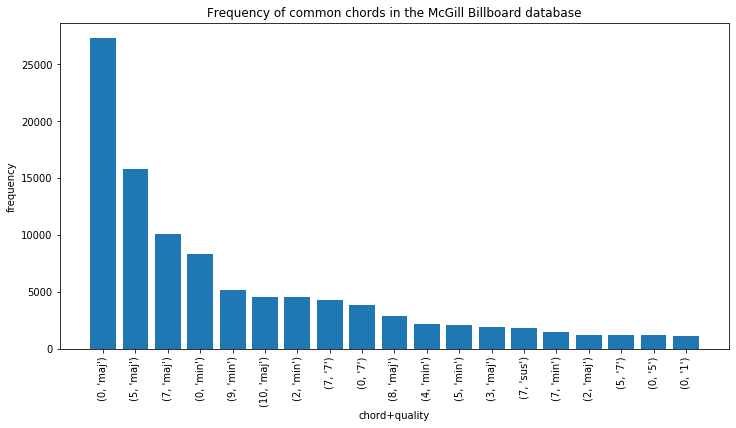

In [8]:
# plot chord and quality
plot_bar(cq_sort,filter_data=True)
plt.title("Frequency of common chords in the McGill Billboard database")
plt.xlabel("chord+quality")
plt.ylabel("frequency")
# print out top 10 chord+quality by count
print(cq_sort[0:10])

#### CHORD ONLY

[(0, 42440), (5, 20280), (7, 18341), (2, 7006), (9, 6810), (10, 5778), (4, 3641), (8, 3362), (3, 2603), (1, 765), (6, 653), (11, 628)]


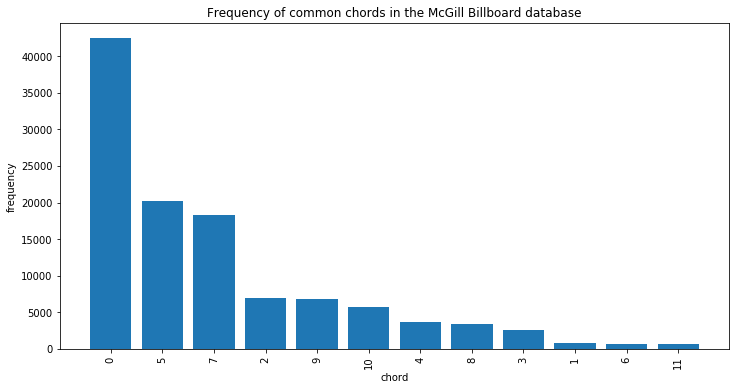

In [9]:
plot_bar(chord_sort)
plt.title("Frequency of common chords in the McGill Billboard database")
plt.xlabel("chord")
plt.ylabel("frequency")
print(chord_sort)

#### QUALITY ONLY

[('maj', 66578), ('min', 24564), ('7', 11782), ('sus', 3736), ('5', 2580), ('1', 2362), ('dim', 510), ('aug', 195)]


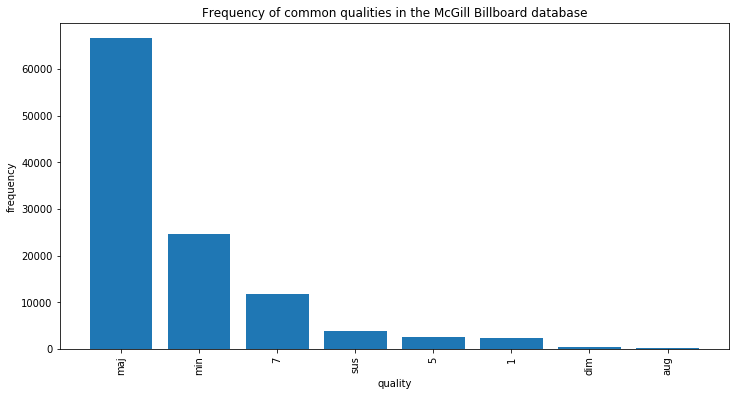

In [10]:
plot_bar(quality_sort)
plt.title("Frequency of common qualities in the McGill Billboard database")
plt.xlabel("quality")
plt.ylabel("frequency")
print(quality_sort)

## Add chord sequence features to pandas dataframe

In [11]:
start = time.time() # start time

# instantiate feature dataframe for all songs
df_features = pd.DataFrame()
# iterate over all song chord progressions
for idx, song_seq in enumerate(song_seq_all):
    # if dict not empty
    if song_seq:
        # initialize row
        df_row = pd.DataFrame()
        # iterate over all key/value pairs
        for kv in song_seq.items():
            # populate dataframe
            df_row.loc[0,str(kv[0])] = kv[1]
        # concatentate df_features
        df_features = df_features.append(
            other=df_row,
            ignore_index=True,
            sort=True
        )
    else:
        df_features = df_features.append(pd.Series(),ignore_index=True)
    # print statement
    if not np.mod(idx,100):
        print("line " + str(idx) + " done")
        
end = time.time() # end time
print("Time elapsed: " + str(end - start)) # time elapsed

# fill NaN values with 0
df_features = df_features.fillna(value=0)

line 0 done
line 100 done
line 200 done
line 300 done
line 400 done
line 500 done
line 600 done
line 700 done
line 800 done
Time elapsed: 179.63704180717468


#### Show head of dataframe

In [12]:
df_features.head()

,"((0, '1'), (0, '5'))","((0, '1'), (0, '5'), (0, '1'))","((0, '1'), (0, '5'), (0, '1'), (0, '5'))","((0, '1'), (0, '5'), (0, '1'), (5, '1'))","((0, '1'), (0, '5'), (0, '1'), (5, 'maj'))","((0, '1'), (0, '5'), (0, 'min'))","((0, '1'), (0, '5'), (0, 'min'), (7, 'min'))","((0, '1'), (0, '5'), (0, 'min'), (8, 'maj'))","((0, '1'), (0, '5'), (3, 'maj'))","((0, '1'), (0, '5'), (3, 'maj'), (10, 'maj'))",...,"((9, 'sus'), (9, 'min'), (4, 'min'))","((9, 'sus'), (9, 'min'), (4, 'min'), (7, 'sus'))","((9, 'sus'), (9, 'min'), (4, 'sus'))","((9, 'sus'), (9, 'min'), (4, 'sus'), (9, 'sus'))","((9, 'sus'), (9, 'min'), (5, 'sus'))","((9, 'sus'), (9, 'min'), (5, 'sus'), (5, 'maj'))","((9, 'sus'), (9, 'min'), (7, 'maj'))","((9, 'sus'), (9, 'min'), (7, 'maj'), (5, '5'))","((9, 'sus'), (9, 'min'), (9, 'sus'))","((9, 'sus'), (9, 'min'), (9, 'sus'), (9, 'min'))"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*large number of features relative to observations, very sparse matrix, "curse of dimensionality"; use PCA for feature reduction*

## Prepare data for machine learning modeling

In [13]:
# import modules from sci-kit learn
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier

#### Principal Component Analysis (PCA) for feature reduction

In [14]:
# apply PCA to features
my_pca = PCA(n_components = 100)

# apply PCA on chord progression features
pc = my_pca.fit_transform(df_features)

# store principal components as dataframe
col_names = ["pc" + str(idx) for idx in range(1,pc.shape[1]+1)] # get PC names
pc_df = pd.DataFrame(data=pc, columns=col_names)                # make dataframe
pc_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc91,pc92,pc93,pc94,pc95,pc96,pc97,pc98,pc99,pc100
0,-9.093352,-1.350986,-2.623216,0.722677,-3.839283,-3.840703,6.223648,-1.921367,-2.355104,2.221718,...,0.715219,-0.034089,0.318575,0.841495,0.361833,-1.360832,1.516585,-0.396743,-0.710891,-0.066217
1,4.246911,-8.630045,-4.961611,1.306482,-2.620420,-1.018286,-1.612576,0.824396,-1.045949,-1.259239,...,0.300303,0.604508,0.837056,-0.517851,0.870119,-0.218909,0.870980,0.222590,0.229038,0.962988
2,-2.980933,17.920002,3.301078,-8.379465,1.637307,-0.826604,-1.302274,8.298869,-3.397145,-0.561750,...,-1.179603,-0.522463,-0.884069,0.315177,1.544618,0.176000,0.321997,-0.717974,-1.527687,-1.817427
3,20.526971,21.738587,2.432120,18.884580,-2.996942,12.469345,-0.160982,-2.962398,0.030949,1.972551,...,1.002131,1.335337,0.349073,-1.144735,-1.247574,-2.200066,0.979634,0.695720,4.510997,0.352982
4,5.501799,4.271461,-0.910192,-2.506989,-0.622665,-1.248524,-0.746093,-2.239343,0.458356,-0.163689,...,0.692137,-0.345869,-1.732872,0.316987,-1.113470,1.819063,-1.293140,-2.283863,-0.144355,-0.586297


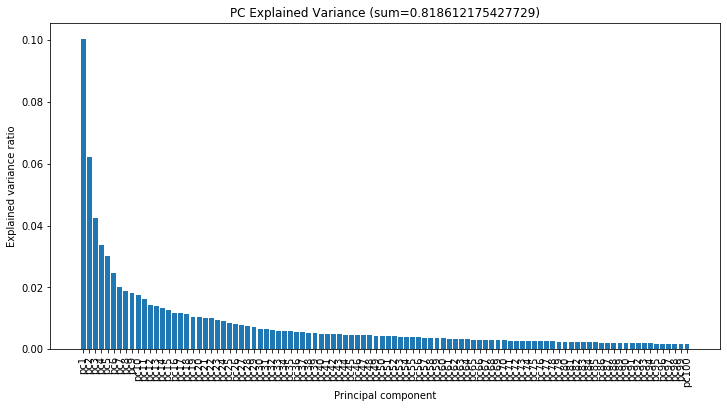

In [15]:
# plot explained variance
evr_list = my_pca.explained_variance_ratio_
my_data = [(name,evr) for name,evr in zip(col_names,evr_list)]
plot_bar(my_data)
plt.title(f"PC Explained Variance (sum={str(np.sum(evr_list))})");
plt.xlabel("Principal component");
plt.ylabel("Explained variance ratio");

In [16]:
# ----------------- ALL DATA ------------------
X_all = pc_df  # PC data
actual_rank = songs_meta_filter_df["actual_rank"]  # actual rank (continuous)
decade = songs_meta_filter_df["decade"]  # decade (categorical)
actual_rank_category = songs_meta_filter_df["actual_rank_category"]  # actual rank category (categorical)

## Build regressors to predict chart rank

#### MULTIVARIATE LINEAR REGRESSION using original features

In [17]:
# instantiate a KFold instance
kf = KFold(n_splits=10, shuffle=True,random_state=10)
# instantiate a linear regression instance
lr = LinearRegression()
# perform cross-validation using linear regression on original chord sequence data
cv_lr = cross_validate(
    estimator=lr,
    X=X_all, y=actual_rank,
    cv=kf,
    scoring=make_scorer(r2_score)
)
cv_lr_df = pd.DataFrame(cv_lr)
cv_lr_df

,fit_time,score_time,test_score
0,0.045704,0.001349,-0.385758
1,0.005254,0.001574,-16.015991
2,0.005194,0.001301,-0.355517
3,0.005212,0.001183,-19.166123
4,0.005396,0.001183,-0.750370
5,0.005270,0.001348,-2.892329
6,0.007088,0.001182,-0.634539
7,0.005176,0.002865,-2.535567
8,0.016177,0.001943,-1.454184
9,0.012885,0.002105,-0.134658


#### K-NEAREST NEIGHBOR REGRESSOR

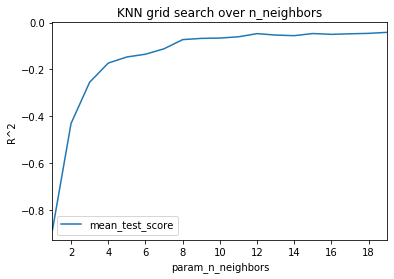

In [18]:
# Create kf instance 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create knn instance 
knn = KNeighborsRegressor()
# Create grid search instance 
gscv = GridSearchCV(knn, {"n_neighbors": range(1, 20)}, cv=kf, n_jobs=-1)
gscv.fit(X_all, actual_rank)
# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)
# Plot results of grid search
cv_df.plot.line(x="param_n_neighbors", y="mean_test_score");
plt.title("KNN grid search over n_neighbors");
plt.ylabel("R^2");

#### RANDOM FOREST REGRESSOR

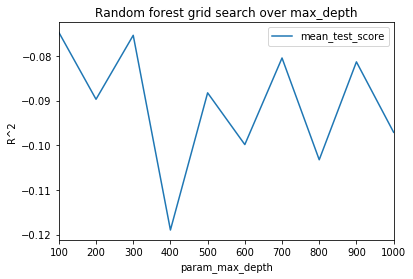

In [19]:
# Create kf instance
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create rf instance
rf = RandomForestRegressor(n_estimators=20)
# Create grid search instance
gscv = GridSearchCV(rf,{"max_depth": range(100,1001,100)},cv=kf, n_jobs=-1)
# Run grid search
gscv.fit(X_all, actual_rank)
# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)
# Plot results of grid search
cv_df.plot.line(x="param_max_depth", y="mean_test_score");
plt.title("Random forest grid search over max_depth");
plt.ylabel("R^2");

# # Create a heatmap-style table
# pivoted_df = cv_df.pivot(index="param_max_depth",
#            columns="param_n_estimators",
#            values="mean_test_score").round(3)
# pivoted_df.style.background_gradient(
#     cmap="nipy_spectral",
#     axis=None
# )

## Build classifiers to predict chart rank category and decade

#### K-NEAREST NEIGHBOR CLASSIFIER

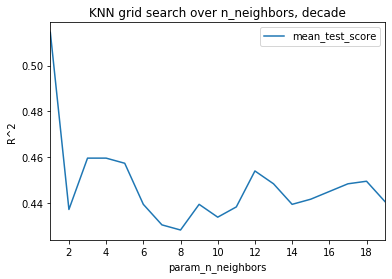

In [20]:
# -------------------- DECADE --------------------
# Create kf instance 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create knn instance 
knn = KNeighborsClassifier()
# Create grid search instance 
gscv = GridSearchCV(knn, {"n_neighbors": range(1, 20)}, cv=kf, n_jobs=-1)
gscv.fit(X_all, decade)
# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)
# Plot results
cv_df.plot.line(x="param_n_neighbors", y="mean_test_score");
plt.title("KNN grid search over n_neighbors, decade");
plt.ylabel("R^2");

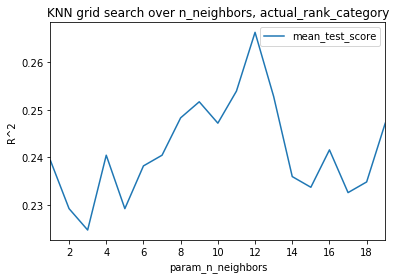

In [21]:
# -------------------- ACTUAL_RANK_CATEGORY --------------------
# Create kf instance 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create knn instance 
knn = KNeighborsClassifier()
# Create grid search instance 
gscv = GridSearchCV(knn, {"n_neighbors": range(1, 20)}, cv=kf, n_jobs=-1)
gscv.fit(X_all, actual_rank_category)
# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)
# Plot results
cv_df.plot.line(x="param_n_neighbors", y="mean_test_score");
plt.title("KNN grid search over n_neighbors, actual_rank_category");
plt.ylabel("R^2");

#### RANDOM FOREST CLASSIFIER

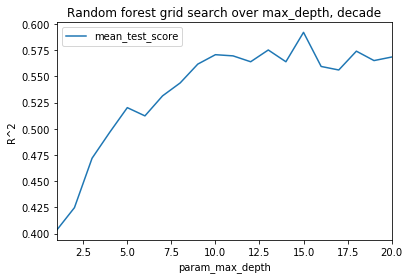

In [22]:
# -------------------- DECADE --------------------
# Create kf instance 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create rf instance 
rf = RandomForestClassifier(n_estimators=20)
# Create grid search instance
gscv = GridSearchCV(rf, {"max_depth": range(1,21)}, cv=kf, n_jobs=-1)
gscv.fit(X_all, decade)
# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)
# Get k values versus mean_test_scores
cv_df.plot.line(x="param_max_depth", y="mean_test_score");
plt.title("Random forest grid search over max_depth, decade");
plt.ylabel("R^2");

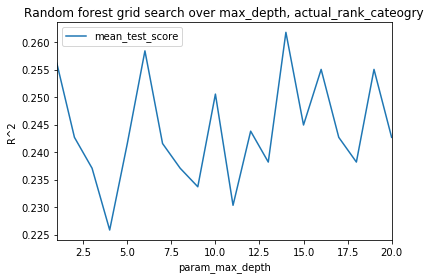

In [23]:
# -------------------- ACTUAL_RANK_CATEGORY --------------------
# Create kf instance 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create rf instance 
rf = RandomForestClassifier(n_estimators=20)
# Create grid search instance
gscv = GridSearchCV(rf, {"max_depth": range(1,21)}, cv=kf, n_jobs=-1)
gscv.fit(X_all, actual_rank_category)
# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)
# Get k values versus mean_test_scores
cv_df.plot.line(x="param_max_depth", y="mean_test_score");
plt.title("Random forest grid search over max_depth, actual_rank_cateogry");
plt.ylabel("R^2");

#### ADABOOST CLASSIFIER (using default decision tree classifier as base)

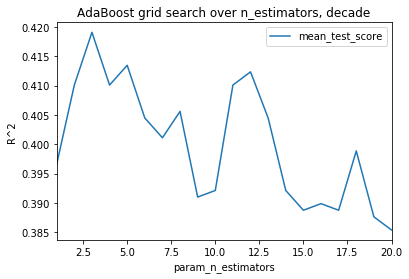

In [24]:
# -------------------- DECADE --------------------
# Create kf instance 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create rf instance 
ada = AdaBoostClassifier(n_estimators=20)
# Create grid search instance
gscv = GridSearchCV(ada, {"n_estimators": range(1,21)}, cv=kf, n_jobs=-1)
gscv.fit(X_all, decade)
# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)
# Get k values versus mean_test_scores
cv_df.plot.line(x="param_n_estimators", y="mean_test_score");
plt.title("AdaBoost grid search over n_estimators, decade");
plt.ylabel("R^2");

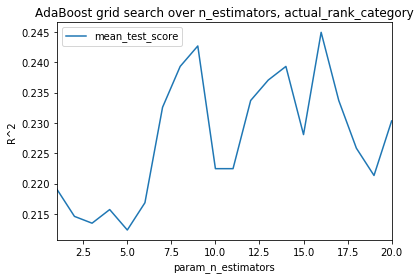

In [25]:
# -------------------- ACTUAL_RANK_CATEGORY --------------------
# Create kf instance 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create rf instance 
ada = AdaBoostClassifier(n_estimators=20)
# Create grid search instance
gscv = GridSearchCV(ada, {"n_estimators": range(1,21)}, cv=kf, n_jobs=-1)
gscv.fit(X_all, actual_rank_category)
# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)
# Get k values versus mean_test_scores
cv_df.plot.line(x="param_n_estimators", y="mean_test_score");
plt.title("AdaBoost grid search over n_estimators, actual_rank_category");
plt.ylabel("R^2");

Potential problems with analysis:
- more features (1365) than observations (890)
- feature matrix was very sparse (a result of songs only containing a handful of unique chord sequences out of all possibilities, and not having many sequences in common with other songs)

Improvements:
- better feature extraction and feature reduction techniques

Future questions to address:
- can you predict a song's rank with the amount of repeated chords? or homogeneity of its chord structure?